# FFT

### Mathematical algorithm description

The DFT equation is 

$$
X[k] = \sum_{n=0}^{N-1} x[n] e^{-j2\pi \frac{nk}{N}}
$$

Dividing into even an odd samples we get

$$
X[k] = \sum_{n=0}^{N/2-1} x[2n] e^{-j2\pi \frac{2nk}{N}} + \sum_{n=0}^{N/2-1} x[2n+1] e^{-j2\pi \frac{(2n+1)k}{N}}
$$

Reorganizing constants, we get to a sumation of two smallers DFTs

$$
X[k] = \sum_{n=0}^{N/2-1} x[2n] e^{-j2\pi \frac{nk}{\frac{N}{2}}} + e^{-j2\pi \frac{k}{N}}\sum_{n=0}^{N/2-1} x[2n+1] e^{-j2\pi \frac{nk}{\frac{N}{2}}}
$$

Which are the DFTs at *k* of the even an odd samples

$$
X[k] = \text{DFT}_{k}^{N/2} \{x[2n]\} + e^{-j2\pi \frac{k}{N}}\text{DFT}_{k+\frac{N}{2}}^{N/2} \{x[2n+1]\}
$$

Now considering that an N/2 DFT is periodic over N/2, we can calculate $X[k+\frac{N}{2}]$ with minimal cost

$$
X[k+\frac{N}{2}] = \text{DFT}_k^{N/2} \{x[2n]\} + e^{-j2\pi \frac{k+N/2}{N}} = -\text{DFT}_k^{N/2} \{x[2n+1]\}
$$

And the odd DFT constant can be further simplified noting that

$$
e^{-j2\pi \frac{k+N/2}{N}} = -e^{-j2\pi \frac{k}{N}}
$$

### Butterfly

Then we get to the following pair of equations:  

Eq. 1:

$$
X[k] = \text{DFT}^{N/2} \{x[2n]\} + e^{-j2\pi \frac{k}{N}}\text{DFT}^{N/2} \{x[2n+1]\}
$$

Eq. 2:  

$$
X[k+\frac{N}{2}] = \text{DFT}^{N/2} \{x[2n]\} - e^{-j2\pi \frac{k}{N}}\text{DFT}^{N/2} \{x[2n+1]\}
$$  

This pair of operations done together compose a *butterfly* operation, and it's the basic operation of an FFT

![butterfly](butterfly.png)  

The two inputs are the results of the DFTs for even and odd samples, for the given k

The type of FFT we are describing is named a radix-2, decimated-in-time FFT

Now we can further extend this process, by applying the same divide scheme to the N/2 DFTs, and again until we end with a single sample. Applying the equation, the DFT of a single sample is the same sample (N=1, k=0). 



In [7]:
def butterfly(i_x,i_y,twiddle,NBT=8):
    o_x = i_x + i_y*twiddle
    o_y = i_x - i_y*twiddle
    
    return o_x,o_y

### Complete butterfly arrangement

The resulting graph for an FFT of size 8 looks as follows

![fft_8_diagram](fft_8_diagram.png)

The way we have described the algorithm so far is recursive, since we arrived at the equation describing the output, but to get the inputs to the equation we need to apply it recursively. 

### Ordering of input samples

From the diagram we can see the output indexes k, but we do not know the input indexes. To get them we need to further explore this recursion.

Note from the equation introducing the butterfly how each sub-DFT takes two sets of input samples, $x[2n]$ (even), and $x[2n+1]$ (odd) samples. These DFTs would be composed by a butterfly from sub-DFTs for the even and odd samples of the even samples, and the even and odd samples of the odd samples.

If we continue this process of splitting even and odd samples from the output to input, we arrive at the input ordering:

 **0     4     2     6     1     5     3     7**

Which can be seen as difficult to get, specially for larger FFTs, but has an interesting property visible when representing the indexes in binary

| Index | Bit representation | Bit reverse | Bit reverse index |
| :---: | :---: | :---: | :---: |
| 0 | 000 | 000 | 0 |
| 1 | 001 | 100 | 4 |
| 2 | 010 | 010 | 2 |
| 3 | 011 | 110 | 6 |
| 4 | 100 | 001 | 1 |
| 5 | 101 | 101 | 5 |
| 6 | 110 | 011 | 3 |
| 7 | 111 | 111 | 7 |

As seen, the ordering can be obtained from reversing the bits representing the original indexes



In [9]:
import numpy as np

def bitrevorder(x):
    x_br=[];
    for idx, s in enumerate(x):
        br_idx = '{:0{width}b}'.format(idx, width=int(np.log2(len(x))))
        bidx = int(br_idx[::-1], 2)
        x_br.append(x[bidx])
    return x_br

print(bitrevorder(range(8)))

[0, 4, 2, 6, 1, 5, 3, 7]


### Twiddle factors

Twiddle factors can be obtained from the FFT equation, at each stage

- Stage 0: $e^{-j2\pi \frac{k}{N}} \quad \text{for} \quad N = 2, k=0$
- Stage 1: $e^{-j2\pi \frac{k}{N}} \quad \text{for} \quad N = 4, k=0,1$
- Stage 2: $e^{-j2\pi \frac{k}{N}} \quad \text{for} \quad N = 8, k=0,1,2,3$

These twiddles can be pre-calculated for the target FFT size.

If we apply the equations we can see that for stage 0, k=0 the required twiddle can be found at index 0 of the last stage twiddle set. For stage 1, k=0 and k=1 twiddles can be found at indexes 0 and 2 of the last stage twiddle set.
Then it will be the case from the mathematical definition that all the FFT required twiddles are contained within the set of twiddles required for the last stage.

In [10]:
def get_twiddles(N,NBT):
    return np.exp(-2*np.pi*1j*np.arange(0,N/2)/N) 


### Internal sample ordering

The FFT is computed by applying log2(N) (because of being a recursive, split in two algorithm) stages of N/2 butterflies (because each butterlfy takes two inputs and generates two outputs), applied to a set of input samples arranged in bit reverse order.

This may seem like a complete description, but it is not. We miss which samples indexes are needed to feed each butterly and the index of which twiddle factor to use.



| Stage | Butterfly | idx0 | idx1 | tf |
| :---: | :---: | :---: | :---: | :---: |
| 0 | 0 | 0 | 1 | 0 |
| 0 | 1 | 2 | 3 | 0 |
| 0 | 2 | 4 | 5 | 0 |
| 0 | 3 | 6 | 7 | 0 |
| 1 | 0 | 0 | 2 | 0 |
| 1 | 1 | 4 | 6 | 0 |
| 1 | 2 | 1 | 3 | 2 |
| 1 | 3 | 5 | 7 | 2 |
| 2 | 0 | 0 | 4 | 0 |
| 2 | 1 | 1 | 5 | 1 |
| 2 | 2 | 2 | 6 | 2 |
| 2 | 3 | 3 | 7 | 3 |

Similarly to what was done for the input ordering, the logic for the internal sample selection can be extracted out of the binary index representation

| Stage | Butterfly | idx0 | idx1 | tf |
| :---: | :---: | :---: | :---: | :---: |
| 0 | 0 | 000 | 001 | 00 |
| 0 | 1 | 010 | 011 | 00 |
| 0 | 2 | 100 | 101 | 00 |
| 0 | 3 | 110 | 111 | 00 |
| 1 | 0 | 000 | 010 | 00 |
| 1 | 1 | 100 | 110 | 00 |
| 1 | 2 | 001 | 011 | 10 |
| 1 | 3 | 101 | 111 | 10 |
| 2 | 0 | 000 | 100 | 00 |
| 2 | 1 | 001 | 101 | 01 |
| 2 | 2 | 010 | 110 | 10 |
| 2 | 3 | 011 | 111 | 11 |


Butterfly samples indexes binary representation can be seen to do a circular shift operation by one when going from one stage to the next.

Twiddle index can be obtained from applying an all zero mask to the butterfly index, and shifting that mask to the right one position per stage, until getting the index fully revealed at the last stage.


In [11]:
import numpy as np

def circshift(b,n): 
    idx=[(x+n)%len(b) for x in range(len(b))]
    return [b[x] for x in idx]    

def get_twiddle_idx(btfly, stage, N):
    return btfly & ((int(N/2-1)<<int(np.log2(N/2)) >> stage))

def get_idx(btfly, stage, N):
    b=list(np.binary_repr(btfly*2, int(np.log2(N))))
    idx0=int(''.join(circshift(b,stage)),2)
    
    b=list(np.binary_repr(btfly*2+1, int(np.log2(N)))) 
    idx1=int(''.join(circshift(b,stage)),2)
    
    tidx = get_twiddle_idx(btfly, stage, N)    
    
    return idx0, idx1, tidx

# Try the index generation
N=8
for stage in range(int(np.log2(N))):
    for bfly in range(int(N/2)):
        print(get_idx(bfly,stage,N)) 

(0, 1, 0)
(2, 3, 0)
(4, 5, 0)
(6, 7, 0)
(0, 2, 0)
(4, 6, 0)
(1, 3, 2)
(5, 7, 2)
(0, 4, 0)
(1, 5, 1)
(2, 6, 2)
(3, 7, 3)


### Putting it all together

The final step in programming the algorithm is combining all the described elements

- Twiddle generation
- Bit reverse input ordering
- Internal sample ordering and twiddle selection
- Dual iteration loops (stages/butterflies)


In [12]:
def my_fft(x,debug=0,NBD=8,NBT=8):
    N = len(x)
    
    # bitrevorder
    x=bitrevorder(x)
        
    # twiddle_gen
    tw = get_twiddles(N,NBT)                                      
    
    # FFT
    for stage in range(0,int(np.log2(N))):
        for btfly in range(0,int(N/2)):
            idx0,idx1,tidx= get_idx(btfly,stage,N)
            if debug:
                print("stage:",stage,"btfly:",btfly," - idx0:", idx0,"idx2:",idx1,"tidx:",tidx," - ", x[idx0],x[idx1],tw[tidx])                
            x[idx0],x[idx1]=butterfly(x[idx0],x[idx1],tw[tidx],NBT)
            if debug:
                print("stage:",stage,"btfly:",btfly," - idx0:", idx0,"idx2:",idx1,"tidx:",tidx," - ", x[idx0],x[idx1],tw[tidx])                
            
    return(x)

### FFT algorithm test

We can test the algorithm implementation by comparing it to numpy's FFT

In [13]:
# Test FFT
data=np.random.normal(size=(16))
print(data)
print(my_fft(data,debug=0)-np.fft.fft(data))

[ 0.33643712  0.18539326  2.12837806  0.38934548 -0.34817942  1.23995226
 -1.02744106  1.01505404  0.28312942 -0.25221132  1.23195419 -0.88446285
 -0.83380593 -1.1020878  -0.82707213 -1.1032387 ]
[ 0.00000000e+00+0.00000000e+00j  4.44089210e-16-8.88178420e-16j
  2.22044605e-16+0.00000000e+00j  4.44089210e-16+2.22044605e-16j
  0.00000000e+00+0.00000000e+00j  2.22044605e-16+2.22044605e-16j
 -2.22044605e-16+0.00000000e+00j  8.88178420e-16-4.44089210e-16j
  0.00000000e+00+0.00000000e+00j -4.44089210e-16+1.33226763e-15j
  2.22044605e-16+0.00000000e+00j -4.44089210e-16-2.22044605e-16j
  0.00000000e+00+0.00000000e+00j -1.11022302e-16-2.22044605e-16j
 -2.22044605e-16+0.00000000e+00j -8.88178420e-16+0.00000000e+00j]



### Algorithm implementation

Operations that the architecture needs to execute

 - Butterfly computation
 - Data propagation/selection
 - Twiddles
 - Input ordering
 
### Main requirement
 
 - Let the implementation be as simple as possible
     - No throughput requirements
     - No latency requirements
     - No strict precision requirements
     - Minimum hardware usage
     - Must fit a 3.5 hour workshop (?)
 - Input number of bits: 8
 - Output number of bits: 8
     
With these requirements one of the simplest architectures is the serial, in place FFT

 - Data arrives one sample at a time
 - Twiddles are stored in a ROM
 - In-place computation, uses a single vector of samples as datapath memory
 - Single butterfly unit
 - Controlled by a general state machine + some counters


### Serial FFT Architecture specification

#### Block diagram

![serial_FFT_arch](serial_FFT_arch.png)

#### Element description

**State machine**

The state machine drives the system through the 3 main modes of operation

 - LOAD
 - PROCESS
 - OUTPUT
 
To do so, it features 4 stages, as shown below

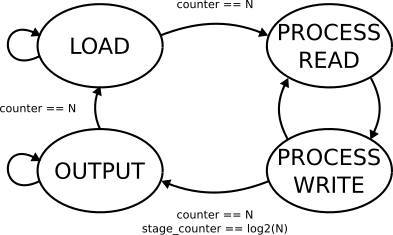

The process part is divided into a PROCESS_READ and PROCESS_WRITE states, for the system to have time to read and write the information to memory.

All states transitions are controlled by a main_counter

**Main counter**

The main counter purpose is to drive state transitions, and also provide the base binary numer to obtian the different needed indexes, which are

    - Bitreverse index for input loading
    - Circular shifted index for butterfly input selection
    - Twiddle selection index
    - Output sample index
    
**Stage counter** 

During processing, there's a separate counter tracking the current stage of operation. Stages go from 0 to log2(N)-1, and the transition from one stage to the next happens when the main counter overflows

**Data RAM**

The data RAM is a true dual port memory. The reason for this architectural selection is for the ability to operate over two arguments at the same time, which makes possible to operate in place without additional delays.

The RAM has a width NBD times 2 (real and imaginary numbers) and a depth of N

**Butterfly**

The butterfly is a purely arithmetic block which takes two complex input samples and one twiddle factor and performs one complex multiplication and two additions to generate two complex outputs.

From our simplicity requirements, operations will be done using fixed-point precision. Here is were the bit-width definitions will affect the blocks signal performance, meaning how accurate the block will represent the mathematical output.

For understanding the arithmetics we need to introduce fixed-point precision notation. Our inputs are 8-bits, in S8.7 format, meaning signed 8-bit precision, with 7 bits for fractional representation. This format will represent numbers from -1 to 1-2^-7, in 2^-7 steps.

Then we need to compute the following two operations

$ x_o = x_i + y_i t$

$ y_o = x_i - y_i t$

the product $y_i t $ is a complex multiplication whose result can be computed as

$\text{RE}\{y_i t\} = \text{RE}\{y_i\} \text{RE}\{t\} - \text{IM}\{y_i\} \text{IM}\{t\} $

$\text{IM}\{y_i t\} = \text{RE}\{y_i\} \text{IM}\{t\} - \text{IM}\{y_i\} \text{RE}\{t\} $

if the twiddle factor $t$ is NBT bits wide, and the input $y_i$ is NBD bits wide, the result of each individual multiplication will have NBD+NBT bits.

While this expansion may be acceptable for a single operation, an FFT contains a chain of butterfly which will rapidly expand the bit-width beyond feasibility. Then we need to adjust the bit-width expansion by introducing truncation, scaling and input constraints.

One input constraint comes from the mathematical definition for twiddles, where we know that the absolute value is always 1. Then if we also constrain the input to be also inside the complex unitary circle, we know that the output will have a maximum absolute value of 1.

This keeps us from having to add one additional bit to the complex multiplier, but we still need to do something with the product expansion. The easiest way to do it is to truncate the extra bits with a shift right operation, but rounding can also be used.

Now we have the issue of the addition. This introduce one additional carry bit, which gives room for the processing gain of the FFT. If we keep this bit the ouput will have log2(N) more bits, so we will shift right by one to agree with the starting requirement of having the same number of output bits as the input



In [14]:
def butterfly(i_x,i_y,twiddle, NBT=16):  
    
    cp = i_y*twiddle / float(2**(NBT-1))
    cpr = np.floor(np.real(cp))
    cpi = np.floor(np.imag(cp))
                  
    o_xr = np.floor((np.real(i_x) + cpr)/2.)
    o_xi = np.floor((np.imag(i_x) + cpi)/2.)
    
    o_yr = np.floor((np.real(i_x) - cpr)/2.)
    o_yi = np.floor((np.imag(i_x) - cpi)/2.)
    return np.complex(o_xr,o_xi),np.complex(o_yr,o_yi)

**Twiddle ROM**

The twiddle ROM contains the N/2 needed twiddles, which are selected by an input index. This block can be generated by a script.



In [15]:
def rnd(x):
    xr = np.floor(x+0.5)
    return xr

def sat(x,NB):    
    xs = (x>2**(NB-1)-1) * (2**(NB-1)-1-x) + (x<-2**(NB-1)) * (-2**(NB-1)-x) + x;    
    return xs

# Fix point redefinition
def get_twiddles(N=8,NBT=16):
    tw = np.exp(-2*np.pi*1j*np.arange(0,N/2)/N)
    twr = np.real(tw)
    twi = np.imag(tw)
    twr = np.floor(twr*2**(NBT-1)+0.5)
    twi = np.floor(twi*2**(NBT-1)+0.5)
    twr = (twr>2**(NBT-1)-1)*(2**(NBT-1)-1)+(twr<=2**(NBT-1)-1)*twr
    twi = (twi>2**(NBT-1)-1)*(2**(NBT-1)-1)+(twi<=2**(NBT-1)-1)*twi
    tw = twr + (0+1j)*twi
    return tw

def write_twiddle_rom(NFFT,NBT):

    f=open('../../rtl/twidde_rom.v','w')
    intro = '''module twiddle_rom
  (input  [%(NBSEL)s-1:0] i_sel,
   output signed [%(NBT)d-1:0]   o_twiddle_real,
   output signed [%(NBT)d-1:0]   o_twiddle_imag);
 
   wire signed [%(NBT)d-1:0] twiddle_real_rom [%(NFFT)d/2-1:0];
   wire signed [%(NBT)d-1:0] twiddle_imag_rom [%(NFFT)d/2-1:0];
 
   assign o_twiddle_real = twiddle_real_rom[i_sel];
   assign o_twiddle_imag = twiddle_imag_rom[i_sel];
\n'''%({'NBSEL':int(np.log2(NFFT/2)),'NBT':NBT,'NFFT':NFFT})
    f.write(intro)
    tw = get_twiddles(NFFT,NBT)
    
    for i in range(int(NFFT/2)):
        f.write('''   assign twiddle_real_rom[%(idx)d] = %(twr)d; \n'''%({'idx':i,'twr':int(np.real(tw[i]))}))
        f.write('''   assign twiddle_imag_rom[%(idx)d] = %(twi)d; \n'''%({'idx':i,'twi':int(np.imag(tw[i]))}))

    f.write('endmodule')
    f.close()

write_twiddle_rom(16,8)

**Bit reverse operation**

This is a reordering of the existing binary counter, not requiring any additional logic.

**Circular shift operation**

The circular shift takes the main counter and the stage counter as inputs and generates a circularly shifted version of the main counter, by as many positions as the current stage count.

**Twidle bit mask**

The twiddle bit mask creates a shifted mask with the amount of shift given by the stage counter. This mask is then used to compute the twiddle index selector.

[ 127.   25. -118.  -71.   91.  106.  -49. -126.    0.  126.   49. -106.
  -91.   71.  118.  -25. -128.  -25.  118.   71.  -91. -106.   49.  126.
    0. -126.  -49.  106.   91.  -71. -118.   25.]
14.7648230602334


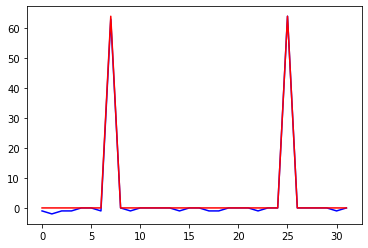

In [17]:
# Test Fix point FFT
from matplotlib import pyplot as plt

NBD = 8
NFFT = 32
freq = 7
data = np.cos(2*np.pi*np.arange(NFFT)/float(NFFT)*freq)*2**(NBD-1)
data = rnd(data)
data = sat(data,NBD)
print(data)

fxp = my_fft(data,NBD=8,NBT=16,debug=0)
flp = np.rint(np.fft.fft(data)/NFFT)

plt.plot(np.real(fxp),'b')
plt.hold=True
plt.plot(np.real(flp),'r')
print(np.abs(np.sum(fxp-flp)))